In [2]:
import numpy as np
import pandas as pd

def load_data(scenario, directory = '/Users/sweiss/src/hete_net/hete_dgp/created_data/'):
  t = np.array(pd.read_csv(directory+'scenario_'+str(scenario)+'_t.csv'))
  t_x = np.array(pd.read_csv(directory+'scenario_'+str(scenario)+'_t_x.csv'))
  x = np.array(pd.read_csv(directory+'scenario_'+str(scenario)+'_x.csv'))
  y = np.array(pd.read_csv(directory+'scenario_'+str(scenario)+'_y.csv'))
  y_mean = np.array(pd.read_csv(directory+'scenario_'+str(scenario)+'_y_mean.csv'))


  t_train = t[:15000]
  t_x_train = t_x[:15000]
  x_train = x[:15000]
  y_train = y[:15000]
  y_train_mean = y_mean[:15000]
    
    
  t_test = t[15000:]
  t_x_test = t_x[15000:]
  x_test = x[15000:]
  y_test = y[15000:]
  y_test_mean  = y_mean[15000:]

  return([t_train, t_test, t_x_train, t_x_test, x_train, x_test, y_train,y_test, y_train_mean, y_test_mean])


def eval(hete_score, y_test, tmt_test):
    y = y_test.copy()
    d = hete_score
    ATE = y_test[tmt_test == 1].mean() - y_test[tmt_test == 0].mean()

    decreasing = np.argsort(d)[::-1]
    y_decreasing = y[decreasing]
    tmt_decreasing = tmt_test[decreasing]
    control_decreasing = 1 - tmt_decreasing
    y_tmt_decreasing = y_decreasing.copy()
    y_tmt_decreasing[control_decreasing == 1] = 0
    y_control_decreasing = y_decreasing.copy()
    y_control_decreasing[tmt_decreasing == 1] = 0

    lhs = y_tmt_decreasing.cumsum() / tmt_decreasing.cumsum()
    rhs = y_control_decreasing.cumsum() / control_decreasing.cumsum()
    N = decreasing.shape[0]
    random_policy = ATE * np.arange(1, N + 1) / N
    optimal_policy = lhs - rhs

    optimal_policy[optimal_policy == -np.inf] = 0
    optimal_policy[optimal_policy == np.inf] = 0
    optimal_policy[np.isnan(optimal_policy)] = 0
    out = optimal_policy - random_policy
    q = np.trapz(out, dx=1/N)
    return q, ATE, optimal_policy, random_policy


def sigmoid(x):
    return(1/(1+np.exp(-x)))
    
def regret(t_true, t_estimate):
    t_true = t_true.reshape(len(t_true), 1)
    t_estimate = t_estimate.reshape(len(t_estimate), 1)

    optim_gain = t_true.copy()
    optim_gain[np.where(optim_gain < 0)[0]] = 0
    optim_gain = sigmoid(optim_gain)
    gains = t_true.copy()
    gains[np.where(t_estimate<0)[0]] = 0
    gains = sigmoid(gains)
    regret = (np.sum(optim_gain) - np.sum(gains))
    return([np.sum(optim_gain) , np.sum(gains)])

def expected_profit(t_true, t_estimate,y_mean,t):
    t = t.reshape(len(t), 1)
    t_true = t_true.reshape(len(t_true), 1)
    y_mean= y_mean.reshape(len(y_mean), 1)
    t_estimate = t_estimate.reshape(len(t_estimate), 1)
    
    
    y_mean =  y_mean - (t - .5)*t_true
    
    optim_gain = y_mean.copy()
    optim_gain[np.where(t_true > 0)[0]] = optim_gain[np.where(t_true > 0)[0]] + .5*t_true[np.where(t_true > 0)[0]]
    optim_gain = sigmoid(optim_gain)
    
    gains = y_mean.copy()
    gains[np.where(t_estimate > 0)[0]] = gains[np.where(t_estimate > 0)[0]] + .5*t_true[np.where(t_estimate > 0)[0]]
    gains = sigmoid(gains)
    return(np.sum(gains)/ np.sum(optim_gain) )



def load_return_score(scenario_number):
    t_train, t_test, t_x_train, t_x_test, X_train, X_test, y_train,y_test, y_train_mean, y_test_mean = load_data(scenario_number, directory = 'created_data/')
    hete_preds = pd.read_csv('/Users/sweiss/src/hete_net/hete_dgp/predicted_data_hete_net/hete_preds_'+str(scenario_number)+'.csv')
    hete_optim = pd.read_csv('/Users/sweiss/src/hete_net/hete_dgp/predicted_data_hete_net/hete_preds_optim_'+str(scenario_number)+'.csv')
    hete_r = pd.read_csv('/Users/sweiss/src/hete_net/hete_dgp/predicted_data_hete_net/hete_R_preds_scenario_'+str(scenario_number)+'_t.csv')
    preds = [hete_preds.iloc[:,1], np.log(hete_optim.iloc[:,2]/hete_optim.iloc[:,1]), hete_r.iloc[:,1]]

    q_score = [eval(x, y_test, t_test)[0] for x in preds]
    accuracy_right = [np.mean( ((t_x_test).reshape(len(x),1)>0) == (x.reshape(len(x),1)>0)) for x in preds]
    regrets = [regret(t_x_test, x) for x in preds]
    expected_profits = [expected_profit(t_x_test, x,y_test_mean, t_test ) for x in preds]
    return([q_score,accuracy_right,regrets,expected_profits])

scores = [load_return_score(x) for x in range(8)]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:100: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:61: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipy

In [6]:
pd.DataFrame(x[3] for x in scores)

,0,1,2
0,1.000000,1.000000,1.000000
1,0.944324,0.953600,0.908762
2,0.815890,0.999405,0.973666
3,0.653770,1.000000,0.454754
4,0.805536,0.813655,0.810838
5,0.929633,0.915042,0.908458
6,0.947985,0.947992,0.926995
7,0.933607,0.975042,0.786281


In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

scenario_number = 2

t_train, t_test, t_x_train, t_x_test, X_train, X_test, y_train,y_test, y_train_mean, y_test_mean = load_data(scenario_number, directory = 'created_data/')
hete_preds = pd.read_csv('/Users/sweiss/src/hete_net/hete_dgp/predicted_data_hete_net/hete_preds_'+str(scenario_number)+'.csv')
hete_optim = pd.read_csv('/Users/sweiss/src/hete_net/hete_dgp/predicted_data_hete_net/hete_preds_optim_'+str(scenario_number)+'.csv')
hete_r = pd.read_csv('/Users/sweiss/src/hete_net/hete_dgp/predicted_data_hete_net/hete_R_preds_scenario_'+str(scenario_number)+'_t.csv')
preds = [hete_preds.iloc[:,1], np.log(hete_optim.iloc[:,2]/hete_optim.iloc[:,1]), hete_r.iloc[:,1]]

q_score = [eval(x, y_test, t_test)[0] for x in preds]
accuracy_right = [np.mean( ((t_x_test).reshape(len(x),1)>0) == (x.reshape(len(x),1)>0)) for x in preds]
regrets = [regret(t_x_test, x) for x in preds]
expected_profits = [expected_profit(t_x_test, x,y_test_mean, t_test ) for x in preds]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:61: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(

In [63]:
expected_profits

[0.8158896086897026, 0.9994053936893676, 0.9736661854180482]

In [64]:
q_score

[0.07847374446110403, -0.051255757078560345, -0.0991910848030285]

In [1]:
df = pd.DataFrame(preds)
pd.tools.plotting.scatter_matrix(df, alpha=0.2)


NameError: name 'pd' is not defined

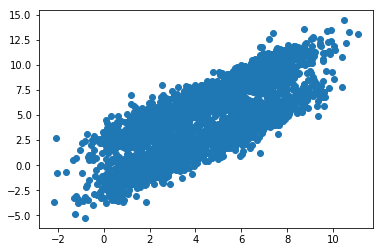

In [46]:
plt.scatter(y_test_mean - (t_test - .5)*t_x_test, y_test_mean)
